<a href="https://colab.research.google.com/github/codingCat06/CNN_Cat-Dog/blob/main/Untitled10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
import torch
from torch import nn
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

train_dir = "./dataset/train"
test_dir = "./dataset/test1/test1"
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(64 * 4 * 4, 256),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(32,2),
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [138]:
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


class CatDog_Dataset(Dataset):
    def __init__(self, file_list, dir_path):
        self.file_list = file_list
        self.transformation = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],    # 각 채널별 정규화 (R,G,B)
                         std=[0.5, 0.5, 0.5])
        ])
        self.dir_path = dir_path

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.dir_path, file_name)
        image = self.transformation(Image.open(file_path))
        label = 0 if "cat" in file_name else 1  # Example label extraction logic
        return image, label

In [139]:
train = CatDog_Dataset(train_files, train_dir)
val = CatDog_Dataset(test_files, test_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [140]:
train_dataset = DataLoader(train, batch_size=32, shuffle=True)
val_dataset = DataLoader(val, batch_size=32, shuffle=False)

In [141]:
samples, labels = next(iter(train_dataset))
print(labels)

print(f"Shape: {samples.shape}")
print(f"Dtype: {samples.dtype}")
print(f"Device: {samples.device}")
print(f"Max: {samples.max()}, Min: {samples.min()}")

tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 0, 0])
Shape: torch.Size([32, 3, 64, 64])
Dtype: torch.float32
Device: cpu
Max: 1.0, Min: -1.0


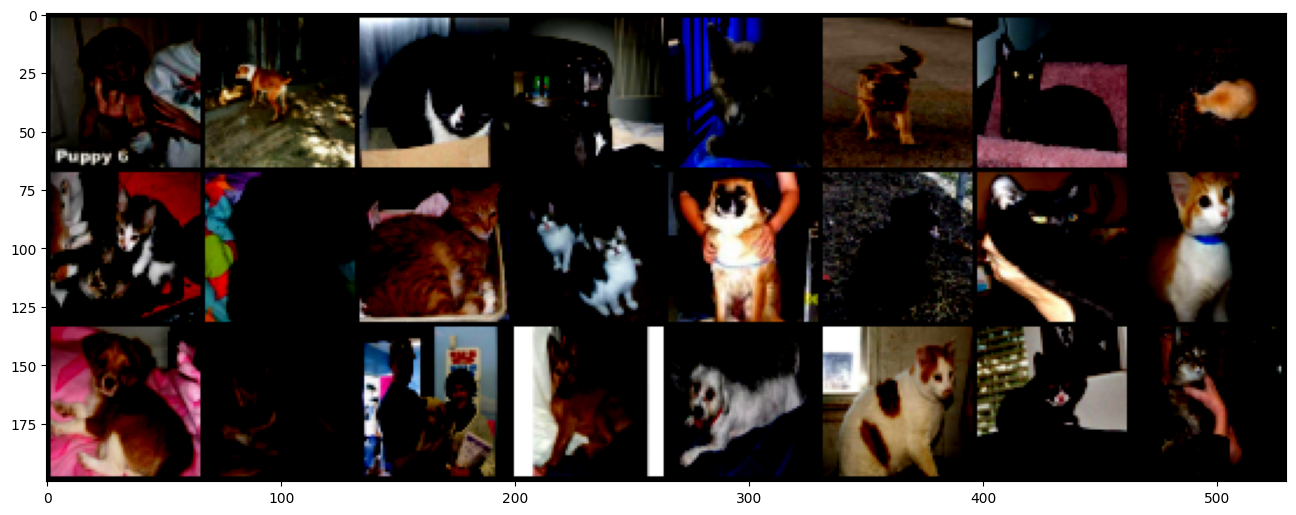

In [142]:
samples, labels = next(iter(train_dataset))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()

plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [143]:
summary(model, input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
              ReLU-2           [-1, 16, 64, 64]               0
           Dropout-3           [-1, 16, 64, 64]               0
         MaxPool2d-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
              ReLU-6           [-1, 32, 32, 32]               0
           Dropout-7           [-1, 32, 32, 32]               0
         MaxPool2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
             ReLU-10           [-1, 64, 16, 16]               0
          Dropout-11           [-1, 64, 16, 16]               0
        MaxPool2d-12             [-1, 64, 8, 8]               0
           Conv2d-13             [-1, 64, 8, 8]          36,928
             ReLU-14             [-1, 6

In [ ]:
from tqdm import tqdm
import torch

train_loss = []
train_accuracy = []
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    print(f"\nEpoch [{epoch+1}/{epochs}]")
    progress_bar = tqdm(train_dataset, desc="Training", leave=False)

    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        current_loss = running_loss / (total / labels.size(0))
        current_acc = correct / total
        progress_bar.set_postfix(loss=f"{current_loss:.4f}", acc=f"{current_acc:.4f}")

    epoch_loss = running_loss / len(train_dataset)
    epoch_accuracy = correct / total
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")




    # Validation loop
    val_correct = 0
    total = 0
    model.eval()

    print("\nValidating...")



    val_correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        val_bar = tqdm(val_dataset, desc="Validation", leave=False)
        for images, labels in val_bar:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_acc_so_far = val_correct / total
            val_bar.set_postfix(acc=f"{val_acc_so_far:.4f}")

    val_accuracy = val_correct / total
    print(f"\nFinal Validation Accuracy: {val_accuracy:.4f}")



Epoch [1/10]


Epoch [1/10] - Loss: 0.6930, Accuracy: 0.5068

Validating...



Final Validation Accuracy: 0.6018

Epoch [2/10]


Epoch [2/10] - Loss: 0.6945, Accuracy: 0.5096

Validating...



Final Validation Accuracy: 1.0000

Epoch [3/10]


Epoch [3/10] - Loss: 0.6932, Accuracy: 0.5023

Validating...



Final Validation Accuracy: 0.0000

Epoch [4/10]


Epoch [4/10] - Loss: 0.6933, Accuracy: 0.4992

Validating...



Final Validation Accuracy: 1.0000

Epoch [5/10]


Epoch [5/10] - Loss: 0.6934, Accuracy: 0.4995

Validating...



Final Validation Accuracy: 0.0000

Epoch [6/10]


Epoch [6/10] - Loss: 0.6933, Accuracy: 0.4982

Validating...



Final Validation Accuracy: 0.0000

Epoch [7/10]


Epoch [7/10] - Loss: 0.6932, Accuracy: 0.4983

Validating...



Final Validation Accuracy: 1.0000

Epoch [8/10]


Epoch [8/10] - Loss: 0.6933, Accuracy: 0.5014

Validating...



Final Validation Accuracy: 0.0000

Epoch [9/10]


Epoch [9/10] - Loss: 0.6934, Accuracy: 0.4962

Validating...



Final Validation Accuracy: 0.0000

Epoch [10/10]


Training:  25%|██▌       | 199/782 [00:15<00:41, 14.05it/s, acc=0.4878, loss=0.6933]

In [ ]:
plt.plot(train_accuracy, label='Train Loss')
plt.legend()
plt.show()
